# Intro

In [1]:
import numpy as np

In [2]:
import networkx as nx
import igraph
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [3]:
from tqdm.notebook import trange, tqdm

# Zachary Karate Club

## *networkx* and *community_louvain*

Zachary Karate Club is already in networkx.

In [4]:
zach_nx = nx.karate_club_graph()

Let's start using the networkx inspired python-louvain module, aka community. 

In [5]:
zach_nx_lou=community_louvain.best_partition(zach_nx, randomize=False)

In [6]:
community_louvain.modularity(zach_nx_lou, zach_nx)

0.4155982905982906

Louvain algorithm is known for being node order dependent, i.e. the modularity of the resulting partition is different when the order of the node of the first step is different.  
Differently from igraph (as we will see in the following), the networkx Louvain is deterministic, once we set the 'randomize' parameter to 'False'. We can set it to 'True', if we want to include this randomness: we can then take the result with the greatest modularity.

  0%|          | 0/1000 [00:00<?, ?it/s]

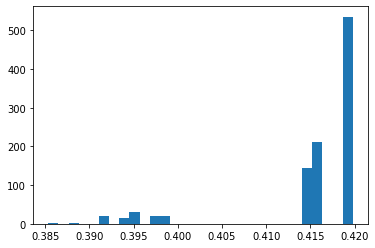

In [7]:
zach_nx_mods=[]
for i in trange(1000):
    _zach_nx_lou=community_louvain.best_partition(zach_nx, randomize=True)
    _mod=community_louvain.modularity(_zach_nx_lou, zach_nx)
    zach_nx_mods.append(_mod)

plt.hist(zach_nx_mods, bins=30)
plt.show()

## *igraph*

Even in the last versions of igraph, the Zachary Karate Club is available:

In [8]:
zach_ig=igraph.Graph.Famous('Zachary')

In [9]:
zach_ig_lou=zach_ig.community_multilevel()

In [10]:
zach_ig.modularity(zach_ig_lou.membership)

0.4151051939513478

igraph's community_multilevel() has a certain degree of randomicity that is not explicited as in community_louvain:

  0%|          | 0/1000 [00:00<?, ?it/s]

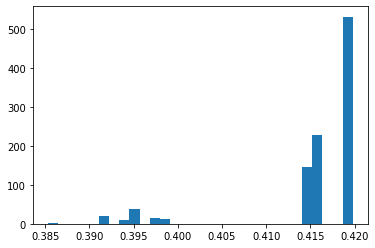

In [11]:
zach_ig_mods=[]
for i in trange(1000):
    _zach_ig_lou=zach_ig.community_multilevel()
    _mod=zach_ig.modularity(_zach_ig_lou.membership)
    zach_ig_mods.append(_mod)

plt.hist(zach_ig_mods, bins=30)
plt.show()

Results in both modules are analogous, but igraph is a little faster.   
In the following I am going to use the one obtained via community_louvain since it permits to control the randomization.

## From Louvain to LouEQ

### One shot

In [12]:
from loueq_native import loueq

Let's steal the edge list from networkx:

In [13]:
zach_el=list(zach_nx.edges)

In [14]:
zach_loueq=loueq(zach_el, randomize=False)


solution error = 4.916070395211136e-08


We automatically have also the value of the exact modularity:

In [15]:
zach_loueq.Q

0.4686907770730598

#### Comparison between the modularities of the various partition 

Nevertheless, since the optimization function is different from the standard one  
(since the null model of the standard one is approximated), let us compare the maximum standard modularity partition with the maximum exact modularity one.

In [16]:
community_louvain.modularity(zach_nx_lou, zach_nx)

0.4155982905982906

In [17]:
community_louvain.modularity(zach_loueq.membership, zach_nx)

0.3404010519395134

For the present case, the partition with the greatest standard modularity is the one found by loueq.  Nevertheless, as we will see in the following, it is a mere accident.

Given a membership as a dict, LouE is able to calculate the exact modularity of the relative partition:

In [18]:
zach_loueq.modularity_exact(zach_nx_lou)

0.4440773941365424

In [19]:
zach_loueq.Q

0.4686907770730598

The exact modularity of the partition found with LouE is greater.

#### Plot

##### Setting the same color for the same communities

LouE provides also the information regarding the community composition:

In [20]:
zach_loueq.communities

{0: [4, 10],
 1: [2, 3, 7, 9, 12, 13],
 2: [5, 6, 16],
 3: [0, 1, 11, 17, 19, 21],
 4: [24, 25, 28, 31],
 5: [23, 26, 27, 29],
 6: [8, 14, 15, 18, 20, 22, 30, 32, 33]}

In [21]:
zach_nx_comm={}
for key in zach_nx_lou.keys():
    _comm=zach_nx_lou[key]
    if _comm in zach_nx_comm.keys():
        zach_nx_comm[_comm].append(key)
    else:
        zach_nx_comm[_comm]=[key]

In [22]:
zach_nx_comm

{1: [0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21],
 3: [4, 5, 6, 10, 16],
 0: [8, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33],
 2: [24, 25, 28, 31]}

In order to properly compare the resulting partition in a plot, let us find a proper translator from the exact modularity communities to the approximated ones.

In [23]:
loue2standard_translator={}
for st_comm in zach_nx_comm.keys():
    benchmark=0
    _loue_comm=-1
    _comm=zach_nx_comm[st_comm]
    for loue_comm in zach_loueq.communities.keys():
        intersection=0
        for c in zach_loueq.communities[loue_comm]:
            if c in _comm:
                intersection+=1
        if benchmark<intersection:
            benchmark=intersection
            _loue_comm=loue_comm
    loue2standard_translator[_loue_comm]=st_comm

Actually, the number of communities found by LouEQ is greater than those found by Louvain.

In [24]:
loue2standard_translator

{1: 1, 2: 3, 6: 0, 4: 2}

In [25]:
not_translated_keys=[]
for key in zach_loueq.communities.keys():
    if key not in loue2standard_translator.keys():
        not_translated_keys.append(key)

In [26]:
for i_key, key in enumerate(not_translated_keys):
    loue2standard_translator[key]=len(zach_nx_comm.keys())+i_key

In [27]:
loue2standard_translator

{1: 1, 2: 3, 6: 0, 4: 2, 0: 4, 3: 5, 5: 6}

In [28]:
zach_colors=['dodgerblue', 'mediumvioletred', 'orange', 'mediumturquoise', 'lime', 'magenta',  'peachpuff']

In [29]:
zach_nn=zach_nx.number_of_nodes()

In [30]:
node_colors_loueq=[zach_colors[loue2standard_translator[zach_loueq.membership[n]]] for n in range(zach_nn)]
node_colors_nx=[zach_colors[zach_nx_lou[n]] for n in range(zach_nn)]

##### Plot

In [31]:
zach_kk_layout=nx.kamada_kawai_layout(zach_nx)

In [32]:
options = {
    "font_size": 16,
    "node_size": 500,
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}

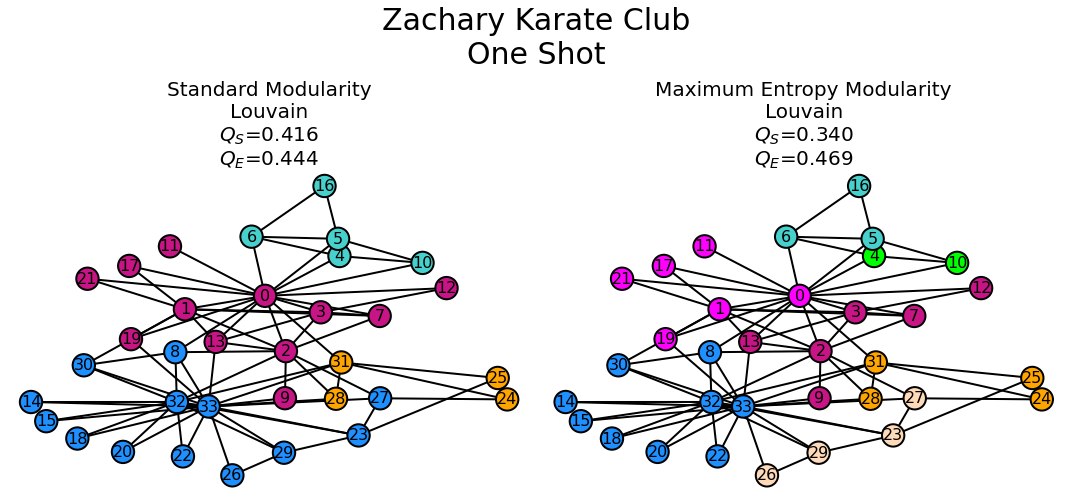

In [33]:
fig, axs=plt.subplots(1,2, figsize=(15,7), sharey=True)
# Standard Modularity Louvain
nx.draw(zach_nx, pos=zach_kk_layout, with_labels=True, **options, node_color=node_colors_nx, ax=axs[0])
# the value of the standard modularity of the present partition
Q_stand_0=community_louvain.modularity(zach_nx_lou, zach_nx)
# the value of the exact modularity of the present partition
Q_mem_0=zach_loueq.modularity_exact(zach_nx_lou)

title_0=('Standard Modularity\nLouvain\n$Q_S$={0:.3f}\n$Q_E$={1:.3f}'.format(Q_stand_0,Q_mem_0))

axs[0].set_title(title_0, fontsize=20)

# Exact Modularity Louvain
nx.draw(zach_nx, pos=zach_kk_layout, with_labels=True, **options, node_color=node_colors_loueq, ax=axs[1])
# the value of the standard modularity of the present partition
Q_stand_1=community_louvain.modularity(zach_loueq.membership, zach_nx)
# the value of the exact modularity of the present partition
Q_mem_1=zach_loueq.Q

title_1='Maximum Entropy Modularity\nLouvain\n$Q_S$={0:.3f}\n$Q_E$={1:.3f}'.format(Q_stand_1,Q_mem_1)
axs[1].set_title(title_1, fontsize=20)

for ax in axs:
    ax.margins(0.05)
fig.suptitle('Zachary Karate Club\nOne Shot', fontsize=30)
plt.axis("off")
plt.tight_layout()
plt.show()

The difference between the two partition is the move of nodes 23 and 27 to the orange community.

### Shuffle

In [34]:
from loueq_native import loueq_loop

As we already saw, the Louvain method is node order dependent. In order to overcome this issue, we can use the class Loup of LouMaxEntMod_Shuffle, deciding the number of run.

In [35]:
zach_loueq_sh=loueq_loop(zach_el, run=1000)

  1%|▏         | 14/1000 [00:00<00:07, 127.77it/s]


solution error = 4.916070395211136e-08


100%|██████████| 1000/1000 [00:08<00:00, 123.42it/s]


In [36]:
zach_loueq_sh.Q

0.5756703590790029

We increased the value of the exact modularity of 

In [37]:
(zach_loueq_sh.Q-zach_loueq.Q)/zach_loueq.Q

0.22825194614245004

which is not that bad! Let us examine what is the analogous increase using standard Louvain algorithm:

In [38]:
mod=0
zach_nx_lou_sh=zach_nx_lou
for i in trange(1000):
    _zach_nx_lou=community_louvain.best_partition(zach_nx, randomize=True)
    _mod=community_louvain.modularity(_zach_nx_lou, zach_nx)
    if mod<_mod:
        mod=_mod
        zach_nx_lou_sh=_zach_nx_lou


  0%|          | 0/1000 [00:00<?, ?it/s]

In [39]:
zach_nx_lou_sh_Q=community_louvain.modularity(zach_nx_lou_sh, zach_nx)
print(zach_nx_lou_sh_Q)

0.4197896120973044


In [40]:
zach_nx_lou_Q=community_louvain.modularity(zach_nx_lou, zach_nx)
print(zach_nx_lou_Q)

0.4155982905982906


Here the increase is much more limited:

In [41]:
(zach_nx_lou_sh_Q-zach_nx_lou_Q)/zach_nx_lou_Q

0.010085030650583334

#### Comparison between the modularities of the various partition 

As we did in the One Shot case, let us compare the different modularity definition for the various partitions.

In [42]:
community_louvain.modularity(zach_nx_lou_sh, zach_nx)

0.4197896120973044

In [43]:
community_louvain.modularity(zach_loueq_sh.membership, zach_nx)

0.37647928994082835

In [44]:
zach_loueq_sh.modularity_exact(zach_nx_lou_sh)

0.464180388770048

In [45]:
zach_loueq_sh.Q

0.5756703590790029

The exact modularity of the partition found with LouE is greater. Indeed, it is something expected, since the optimization function, even if close, are different.

#### Plot

##### Setting the same color for the same communities

The organization of the information inside LouEQ_Loop is analogous to the one of LouEQ:

In [46]:
zach_loueq_sh.communities

{0: [23, 26, 27, 29],
 1: [0, 4, 5, 6, 10, 11, 16, 19],
 2: [8, 14, 15, 18, 20, 22, 30, 32, 33],
 3: [24, 25, 28, 31],
 4: [1, 2, 3, 7, 9, 12, 13, 17, 21]}

In [47]:
zach_nx_comm_sh={}
for key in zach_nx_lou_sh.keys():
    _comm=zach_nx_lou_sh[key]
    if _comm in zach_nx_comm_sh.keys():
        zach_nx_comm_sh[_comm].append(key)
    else:
        zach_nx_comm_sh[_comm]=[key]

In [48]:
zach_nx_comm_sh

{0: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21],
 2: [4, 5, 6, 10, 16],
 1: [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33],
 3: [23, 24, 25, 27, 28, 31]}

In order to properly compare the resulting partition in a plot, let us find a proper translator from the exact modularity communities to the approximated ones.

In [49]:
loue2standard_translator_sh={}
for st_comm in zach_nx_comm_sh.keys():
    benchmark=0
    _loue_comm=-1
    _comm=zach_nx_comm_sh[st_comm]
    for loue_comm in zach_loueq_sh.communities.keys():
        intersection=0
        for c in zach_loueq_sh.communities[loue_comm]:
            if c in _comm:
                intersection+=1
        if benchmark<intersection:
            benchmark=intersection
            _loue_comm=loue_comm
    loue2standard_translator_sh[_loue_comm]=st_comm

Actually, standard Louvain display a community less than LouEQ.

In [50]:
loue2standard_translator_sh

{4: 0, 1: 2, 2: 1, 3: 3}

In [51]:
zach_colors=['dodgerblue', 'mediumvioletred', 'orange', 'mediumturquoise', 'lime', 'magenta']

In [52]:
zach_nn=zach_nx.number_of_nodes()

In [53]:
loue2standard_translator_sh

{4: 0, 1: 2, 2: 1, 3: 3}

In [54]:
not_translated_keys=[]
for key in zach_loueq_sh.communities.keys():
    if key not in loue2standard_translator_sh.keys():
        not_translated_keys.append(key)

In [55]:
for i_key, key in enumerate(not_translated_keys):
    loue2standard_translator_sh[key]=len(zach_nx_comm_sh.keys())+i_key

In [56]:
loue2standard_translator_sh

{4: 0, 1: 2, 2: 1, 3: 3, 0: 4}

In [57]:
node_colors_loueq_sh=[zach_colors[loue2standard_translator_sh[zach_loueq_sh.membership[n]]] for n in range(zach_nn)]
node_colors_nx_sh=[zach_colors[zach_nx_lou_sh[n]] for n in range(zach_nn)]

##### Plot

In [58]:
zach_kk_layout=nx.kamada_kawai_layout(zach_nx)

In [59]:
options = {
    "font_size": 16,
    "node_size": 500,
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}

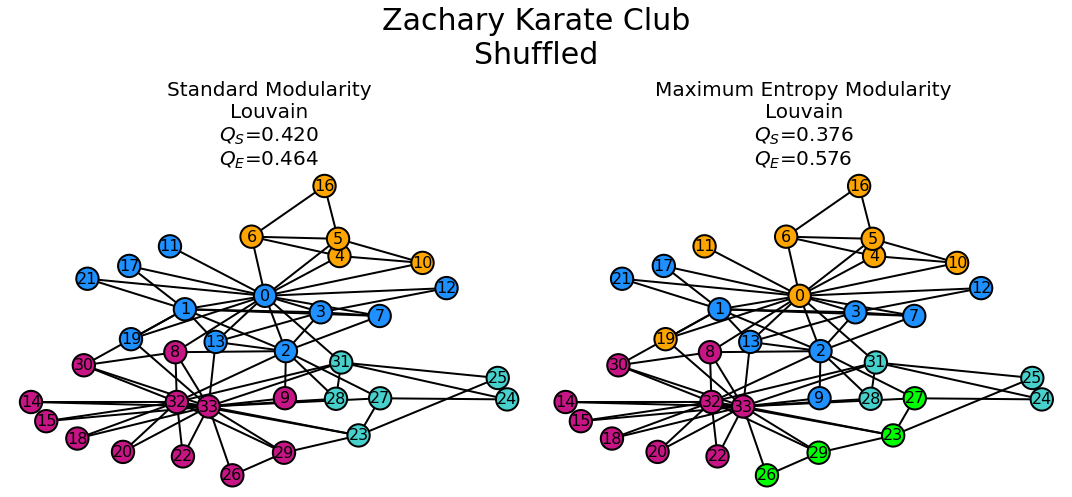

In [60]:
fig, axs=plt.subplots(1,2, figsize=(15,7), sharey=True)
# Standard Modularity Louvain
nx.draw(zach_nx, pos=zach_kk_layout, with_labels=True, **options, node_color=node_colors_nx_sh, ax=axs[0])
# the value of the standard modularity of the present partition
Q_stand_0=community_louvain.modularity(zach_nx_lou_sh, zach_nx)
# the value of the exact modularity of the present partition
Q_mem_0=zach_loueq.modularity_exact(zach_nx_lou_sh)

title_0=('Standard Modularity\nLouvain\n$Q_S$={0:.3f}\n$Q_E$={1:.3f}'.format(Q_stand_0,Q_mem_0))

axs[0].set_title(title_0, fontsize=20)

# Exact Modularity Louvain
nx.draw(zach_nx, pos=zach_kk_layout, with_labels=True, **options, node_color=node_colors_loueq_sh, ax=axs[1])
# the value of the standard modularity of the present partition
Q_stand_1=community_louvain.modularity(zach_loueq_sh.membership, zach_nx)
# the value of the exact modularity of the present partition
Q_mem_1=zach_loueq_sh.Q

title_1='Maximum Entropy Modularity\nLouvain\n$Q_S$={0:.3f}\n$Q_E$={1:.3f}'.format(Q_stand_1,Q_mem_1)
axs[1].set_title(title_1, fontsize=20)

for ax in axs:
    ax.margins(0.05)
fig.suptitle('Zachary Karate Club\nShuffled', fontsize=30)
plt.axis("off")
plt.tight_layout()
plt.show()

Actually, there is a quite big difference in the result here: node 0, 11 and 19 pass from the purple to the orange community and it is a big change: node 0 is the master of the dojo! Nevertheless, the main division between the master and the officer's groups is still present.  
The other nodes changing group are node 9 (**which is known to be quite sensible**: she/he remain with the officer group due to the black belt exam, even if she/he was closer to the master) and nodes 23, 26, 27 and 29 (that form a community on their own).

## Why the exact modularity is needed and why it is not the difference is not observed in the Zachary Karate Club

In [61]:
from loueq_native import MaxEntCM, p_func

Let us consider the nodes with the greatest degree, i.e node 0 and node 33 (respectively the karate master and the university officer of the Zachary Karate Club). As expected, the 2 nodes are not connected:

In [62]:
(0,33) in zach_nx.edges

False

In this sense, we already know that the maximization of the standard modularity will probably point to a partition in which the two terms are in different community, since the relative entry for the modularity would be negative:
$$
a_{0\,33}-p_{0\,33}=-p_{0\,33}<0
$$

Let us calculate the probability of connecting the two terms, using the Chung-Lu configuration model, i.e. $p_{ij}=\dfrac{k_ik_j}{2m}$:

In [63]:
k_0=zach_nx.degree[0]
k_33=zach_nx.degree[33]
m=zach_nx.number_of_edges()

In [64]:
k_0*k_33/2/m

1.7435897435897436

which is greater than 1! Actually, as already said above, in the case of the Zachary Karate Club, the issue is not a big one, since the relative entry for the couple (0,33) was already negative.  
Remarkably, it would have been negative even in the case in which nodes 0 and 33 would have been connected!  
This is not the case when using the exact configuration model:

In [65]:
nodes, fitness_dict=MaxEntCM(zach_el)


solution error = 4.916070395211136e-08


In [66]:
p_func(fitness_dict[0],fitness_dict[33])

0.9357552599990584

The probability of connecting the two nodes is high, but still lower than 1.

#### Is it always this case?
Otherwise stated, is the case in which the probability of connection is greater than one **AND** the two nodes are connected? This can create an issue, since the related nodes are disfavored to be included in the same community due to the approximation, while in principle could be in the same community.

Let us define a function that returns the Chung-Lu probability of connection:

In [67]:
def modularity_link_entry(edge):
    k_0=zach_nx.degree[edge[0]]
    k_1=zach_nx.degree[edge[1]]
    return 1-k_0*k_1/2/m

Let's look for the couple of nodes that are not in the same standard modularity community due to the wrong normalization of the probability.

In [68]:
for edge in tqdm(zach_el):
    if modularity_link_entry(edge)<0:
        same_loueq_memb=zach_loueq_sh.membership[edge[0]]==zach_loueq_sh.membership[edge[1]]
        same_nx_memb=zach_nx_lou_sh[edge[0]]==zach_nx_lou_sh[edge[1]]
        if same_nx_memb==False and same_loueq_memb==True:
            print('found!')
            print(edge, modularity_link_entry(edge))

  0%|          | 0/78 [00:00<?, ?it/s]

Luckily, there is only a problematic entry, that nevertheless does not create any issue since the two hubs are disconnected.

# St. Louis Jazz

Let us consider instead a different data set, i.e. the one of jazz musician collaborations in St. Louis.  
The dataset is taken from [here](http://konect.cc/networks/arenas-jazz/) and refers to the publication by Gleiser and Danon [here](https://www.worldscientific.com/doi/abs/10.1142/S0219525903001067).

In [69]:
jazz_el=np.genfromtxt('out.arenas-jazz', delimiter='\t', skip_header=1, dtype='i8')-1

In [70]:
jazz_el

array([[  0,   9],
       [  0,  10],
       [  0,  11],
       ...,
       [186, 188],
       [187, 188],
       [192, 193]])

(the -1 is needed since the first node is 1).

In [71]:
jazz_nl=np.unique(jazz_el)

## _networkx_ and *community_louvain*

In [72]:
jazz_nx=nx.Graph()
jazz_nx.add_nodes_from(jazz_nl)
jazz_nx.add_edges_from(jazz_el)

In [73]:
jazz_nx_lou=community_louvain.best_partition(jazz_nx, randomize=False)

In [74]:
jazz_nx_lou_Q=community_louvain.modularity(jazz_nx_lou, jazz_nx)
print(jazz_nx_lou_Q)

0.4445179292215907


In [75]:
mod=0
jazz_nx_lou_sh=jazz_nx_lou
for i in trange(1000):
    _jazz_nx_lou=community_louvain.best_partition(jazz_nx, randomize=True)
    _mod=community_louvain.modularity(_jazz_nx_lou, jazz_nx)
    if mod<_mod:
        mod=_mod
        jazz_nx_lou_sh=_jazz_nx_lou


  0%|          | 0/1000 [00:00<?, ?it/s]

In [76]:
jazz_nx_lou_sh_Q=community_louvain.modularity(jazz_nx_lou_sh, jazz_nx)
print(jazz_nx_lou_sh_Q)

0.4451438466175189


In [77]:
(jazz_nx_lou_sh_Q-jazz_nx_lou_Q)/jazz_nx_lou_Q

0.00140808132761758

## LouEQ Shuffle

In [78]:
jazz_loueq=loueq(jazz_el, randomize=False)


solution error = 1.205675062010414e-07


In [79]:
jazz_loueq.Q

0.22903802115761357

In [80]:
jazz_loueq_sh=loueq_loop(jazz_el, run=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]


solution error = 1.205675062010414e-07


100%|██████████| 1000/1000 [08:12<00:00,  2.03it/s]


In [81]:
jazz_loueq_sh.Q

0.31240372656030646

We increased the value of the exact modularity of 

In [82]:
(jazz_loueq_sh.Q-jazz_loueq.Q)/jazz_loueq.Q

0.36398194929096245

## Why such a modification is needed and why it DOES make the difference in the St. Louis Jazz data set

Let us check for the greatest degree nodes:

In [83]:
max_k=0
node_max_k=None
second_max_k=0
node_second_max_k=None
for n in jazz_nx.nodes:
    k_n=jazz_nx.degree(n)
    if k_n>max_k:
        max_k=k_n
        node_max_k=n
    elif k_n>second_max_k:
        second_max_k=k_n
        node_second_max_k=n

In [84]:
print(node_max_k, max_k)
print(node_second_max_k, second_max_k)

66 100
19 75


Differently from Zachary Karate Club, in St.Louis Jazz data set, the greatest degree nodes are connected:

In [85]:
(19, 66) in jazz_nx.edges

True

Let us calculate the probability of connecting the two terms, using the Chung-Lu configuration model, i.e. $p_{ij}=\dfrac{k_ik_j}{2m}$:

In [86]:
k_19=jazz_nx.degree[19]
k_66=jazz_nx.degree[66]
m=jazz_nx.number_of_edges()

In [87]:
k_19*k_66/2/m

1.3676148796498906

which is greater than 1!  
Actually, this is a great issue: even if node 19 and 66 are put in the same community, the relative contribution is still negative, since $p_{ij}>1$ (so $a_{ij}-p_{ij}<0$)!  
Again, this is not the case when using the exact configuration model:

In [88]:
nodes, fitness_dict=MaxEntCM(jazz_el)


solution error = 1.205675062010414e-07


In [89]:
p_func(fitness_dict[19],fitness_dict[66])

0.8534398852952038

The probability of connecting the two nodes is high, but still lower than 1.  
Luckily, the 2 partitions (standard and exact Louvain) find again the two nodes in different communities.

In [90]:
jazz_nx_lou_sh[19]==jazz_nx_lou_sh[66]

False

In [91]:
jazz_loueq_sh.membership[19]==jazz_loueq_sh.membership[66]

False

#### Is it always this case?

Let us define a function that returns the Chung-Lu probability of connection:

In [92]:
def modularity_link_entry(edge):
    k_0=jazz_nx.degree[edge[0]]
    k_1=jazz_nx.degree[edge[1]]
    return 1-k_0*k_1/2/m

Let's look for the couple of nodes that are not in the same standard modularity community due to the wrong normalization of the probability but are properly assigned by the exact modularity Louvain.

In [93]:
problematic_edges=[]
for edge in tqdm(jazz_el):
    if modularity_link_entry(edge)<0:
        same_loueq_memb=jazz_loueq_sh.membership[edge[0]]==jazz_loueq_sh.membership[edge[1]]
        same_nx_memb=jazz_nx_lou_sh[edge[0]]==jazz_nx_lou_sh[edge[1]]
        if same_nx_memb==False and same_loueq_memb==True:
            print('found!')
            print(edge, modularity_link_entry(edge))
            problematic_edges.append(tuple(edge))

  0%|          | 0/2742 [00:00<?, ?it/s]

found!
[ 66 116] -0.0029175784099197966
found!
[66 89] -0.1305616338439095


In [94]:
problematic_edges

[(66, 116), (66, 89)]

In [95]:
problematic_nodes=np.unique(problematic_edges)

## Plot

##### Setting the same color for the same communities

In [96]:
jazz_nx_comm_sh={}
for key in jazz_nx_lou_sh.keys():
    _comm=jazz_nx_lou_sh[key]
    if _comm in jazz_nx_comm_sh.keys():
        jazz_nx_comm_sh[_comm].append(key)
    else:
        jazz_nx_comm_sh[_comm]=[key]

In order to properly compare the resulting partition in a plot, let us find a proper translator from the exact modularity communities to the approximated ones.

In [97]:
loue2standard_translator_sh={}
for st_comm in jazz_nx_comm_sh.keys():
    benchmark=0
    _loue_comm=-1
    _comm=jazz_nx_comm_sh[st_comm]
    for loue_comm in jazz_loueq_sh.communities.keys():
        intersection=0
        for c in jazz_loueq_sh.communities[loue_comm]:
            if c in _comm:
                intersection+=1
        if benchmark<intersection:
            benchmark=intersection
            _loue_comm=loue_comm
    loue2standard_translator_sh[_loue_comm]=st_comm

Actually, we are in the easy situation in which the number of communities is the same using the standard Louvain or the exact modularity one.

In [98]:
len(jazz_nx_comm_sh.keys())

4

In [99]:
len(jazz_loueq_sh.communities.keys())

7

In [100]:
jazz_colors=['dodgerblue', 'mediumvioletred', 'orange', 'mediumturquoise', 'lime', 'magenta',  'peachpuff']

In [101]:
jazz_nn=jazz_nx.number_of_nodes()

In [102]:
not_translated_keys=[]
for key in jazz_loueq_sh.communities.keys():
    if key not in loue2standard_translator_sh.keys():
        not_translated_keys.append(key)

In [103]:
for i_key, key in enumerate(not_translated_keys):
    loue2standard_translator_sh[key]=len(jazz_nx_comm_sh.keys())+i_key

In [104]:
loue2standard_translator_sh

{4: 0, 1: 1, 2: 2, 5: 3, 0: 4, 3: 5, 6: 6}

In [105]:
node_colors_loueq_sh=[jazz_colors[loue2standard_translator_sh[jazz_loueq_sh.membership[n]]] for n in range(jazz_nn)]
node_colors_nx_sh=[jazz_colors[jazz_nx_lou_sh[n]] for n in range(jazz_nn)]

##### Plot

In [106]:
jazz_kk_layout=nx.kamada_kawai_layout(jazz_nx)

In [107]:
options = {
    "font_size": 8,
    "node_size": 250,
    "edgecolors": "black",
    "linewidths": 1,
    "width": .5,
}

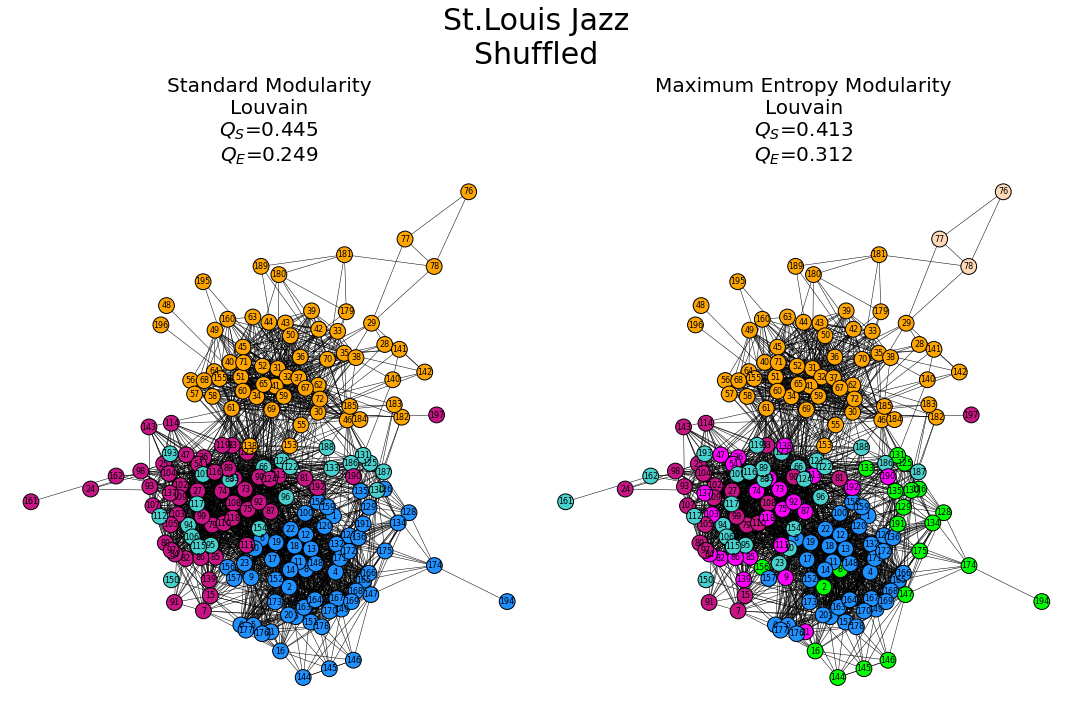

In [108]:
fig, axs=plt.subplots(1,2, figsize=(15,10), sharey=True)
# Standard Modularity Louvain
nx.draw(jazz_nx, pos=jazz_kk_layout, with_labels=True, **options, node_color=node_colors_nx_sh, ax=axs[0])
# the value of the standard modularity of the present partition
Q_stand_0=community_louvain.modularity(jazz_nx_lou_sh, jazz_nx)
# the value of the exact modularity of the present partition
Q_mem_0=jazz_loueq.modularity_exact(jazz_nx_lou_sh)

title_0=('Standard Modularity\nLouvain\n$Q_S$={0:.3f}\n$Q_E$={1:.3f}'.format(Q_stand_0,Q_mem_0))

axs[0].set_title(title_0, fontsize=20)

# Exact Modularity Louvain
nx.draw(jazz_nx, pos=jazz_kk_layout, with_labels=True, **options, node_color=node_colors_loueq_sh, ax=axs[1])
# the value of the standard modularity of the present partition
Q_stand_1=community_louvain.modularity(jazz_loueq_sh.membership, jazz_nx)
# the value of the exact modularity of the present partition
Q_mem_1=jazz_loueq_sh.Q

title_1='Maximum Entropy Modularity\nLouvain\n$Q_S$={0:.3f}\n$Q_E$={1:.3f}'.format(Q_stand_1,Q_mem_1)
axs[1].set_title(title_1, fontsize=20)

for ax in axs:
    ax.margins(0.05)
fig.suptitle('St.Louis Jazz\nShuffled', fontsize=30)
plt.axis("off")
plt.tight_layout()
plt.show()

Since the network is relatively big, it is hard to distinguish anything. Let us therefore focus on the problematic nodes.

In [109]:
# Taken from https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, 1-amount * c[1])), c[2])

In [110]:
node_colors_loueq_sh_focus=[]
node_colors_nx_sh_focus=[]
for n in range(jazz_nn):
    color_loueq=node_colors_loueq_sh[n]
    color_nx=node_colors_nx_sh[n]
    if n in problematic_nodes:
        node_colors_loueq_sh_focus.append(color_loueq)
        node_colors_nx_sh_focus.append(color_nx)
    else:
        node_colors_loueq_sh_focus.append(adjust_lightness(color_loueq, .15))
        node_colors_nx_sh_focus.append(adjust_lightness(color_nx, .15))

/home/sarawalk/twitter_pai/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


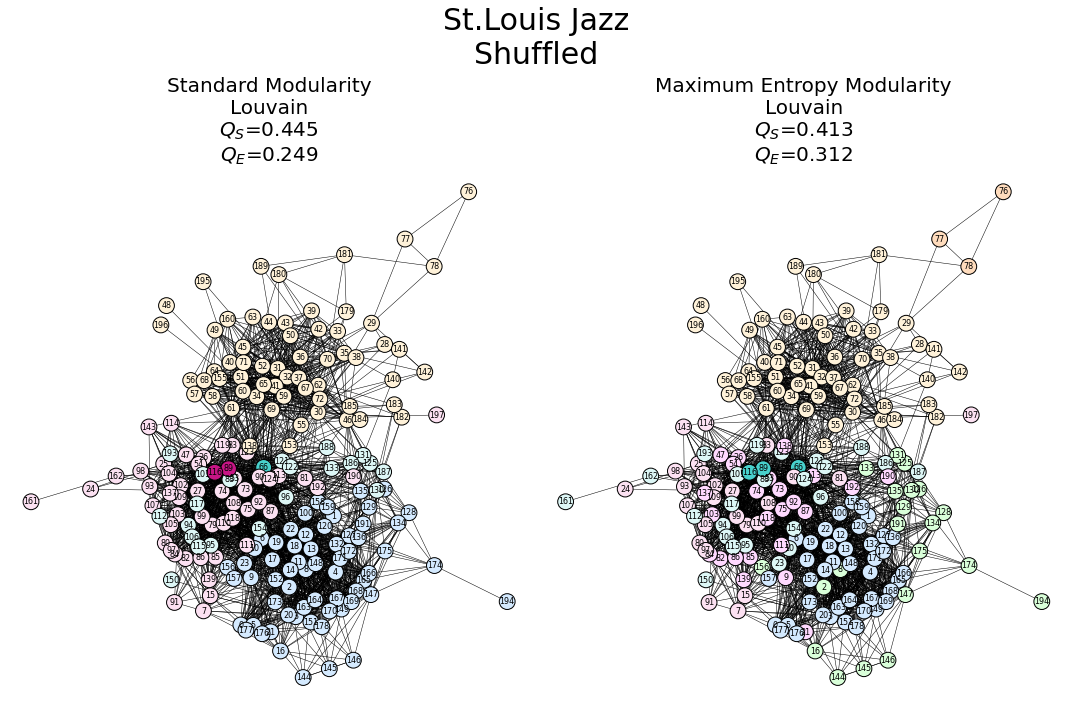

In [111]:
fig, axs=plt.subplots(1,2, figsize=(15,10), sharey=True)
# Standard Modularity Louvain
nx.draw(jazz_nx, pos=jazz_kk_layout, with_labels=True, **options, node_color=node_colors_nx_sh_focus, ax=axs[0])
# the value of the standard modularity of the present partition
Q_stand_0=community_louvain.modularity(jazz_nx_lou_sh, jazz_nx)
# the value of the exact modularity of the present partition
Q_mem_0=jazz_loueq.modularity_exact(jazz_nx_lou_sh)

title_0=('Standard Modularity\nLouvain\n$Q_S$={0:.3f}\n$Q_E$={1:.3f}'.format(Q_stand_0,Q_mem_0))

axs[0].set_title(title_0, fontsize=20)

# Exact Modularity Louvain
nx.draw(jazz_nx, pos=jazz_kk_layout, with_labels=True, **options, node_color=node_colors_loueq_sh_focus, ax=axs[1])
# the value of the standard modularity of the present partition
Q_stand_1=community_louvain.modularity(jazz_loueq_sh.membership, jazz_nx)
# the value of the exact modularity of the present partition
Q_mem_1=jazz_loueq_sh.Q

title_1='Maximum Entropy Modularity\nLouvain\n$Q_S$={0:.3f}\n$Q_E$={1:.3f}'.format(Q_stand_1,Q_mem_1)
axs[1].set_title(title_1, fontsize=20)

for ax in axs:
    ax.margins(0.05)
fig.suptitle('St.Louis Jazz\nShuffled', fontsize=30)
plt.axis("off")
plt.tight_layout()
plt.show()

Since the standard modularity entry of the problematic edges is negative -something that should not be in general, but it is due to the approximation of the standard CM- nodes are in different communities. This behavior is not observed once the null-model is exact.

# TODO
~~- Find a data set in which two hubs are connected **AND** in the same community;~~  
~~- Fix the way to check if a link is present in St. Louis Jazz data set (it always returns "True");~~
- try using numba in order to run faster.